In [75]:
import pandas as pd
from pypfopt import EfficientFrontier
from sklearn.covariance import ShrunkCovariance
import os
import numpy as np
import matplotlib.pyplot as plt

In [76]:
data = pd.read_csv("features.csv")[65:]
data_test = pd.read_csv("results_all/xgb_test.csv")
open_cols = [col for col in data.columns if "OPEN" in col]
coins = set([col.split("_")[-1] for col in open_cols])


In [77]:
log_ret_cols = [col for col in data.columns if "Log_RET" in col]
log_ret_pred_cols = [col for col in data_test.columns if "Log_RET" in col]
log_ret_pred_cols = [col for col in log_ret_pred_cols if "_pred" in col]

In [78]:
#FOR HISTORIC MEAN RETURNS
data_to_consider = data[0:-data_test.shape[0]]
for coin in coins:
    data_test["historic_mean_{}".format(coin)] = data["Log_RET_{}".format(coin)].mean()

log_ret_hist_mean_cols = [col for col in data_test.columns if "historic_mean_" in col]


In [79]:
n_all = data.shape[0]

In [80]:
n_test = data_test.shape[0]

In [81]:
lookforward = 1

In [101]:
i = 0
df_ret_pred = data_test[log_ret_pred_cols][:-1].reset_index(drop=True)
df_ret_true = data_test[log_ret_cols][1:].reset_index(drop=True)


In [84]:
weightsV = []
for i in range(0, n_test-1):
    df_cov = data[log_ret_cols]
    df_ret_pred = data_test[log_ret_pred_cols][:-1]
    ret_for_cov = df_cov[0:n_all - i]
    ret_pred = df_ret_pred.iloc[i]
    cov = ShrunkCovariance().fit(ret_for_cov).covariance_
    #calculate the portfolio weights
    ef = EfficientFrontier(ret_pred, cov, weight_bounds=(0,1))
    weights = ef.max_sharpe(risk_free_rate=0)
    cleaned_weights = ef.clean_weights()
    weightsV.append(cleaned_weights)

<AxesSubplot:>

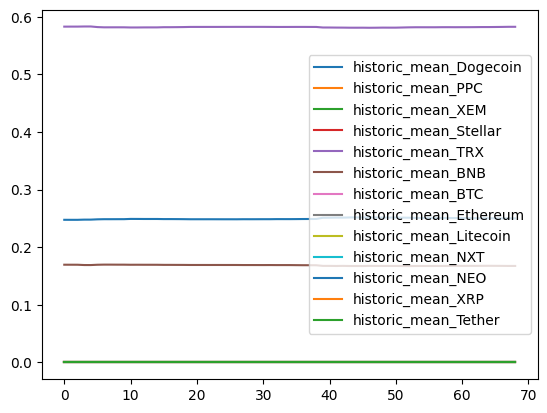

In [85]:
#IF USING HISTORICAL MEANS PORTFOLIO USE THIS CODE
weights_hist_mean = []
for i in range(0, n_test-1):
    df_cov = data[log_ret_cols]
    df_ret_hist_mean = data_test[log_ret_hist_mean_cols][:-1]
    ret_for_cov = df_cov[0:n_all - i]
    ret_mean = df_ret_hist_mean.iloc[i]
    cov = ShrunkCovariance().fit(ret_for_cov).covariance_
    #calculate the portfolio weights
    ef = EfficientFrontier(ret_mean, cov, weight_bounds=(0,1))
    weights = ef.max_sharpe(risk_free_rate=0)
    cleaned_weights = ef.clean_weights()
    weights_hist_mean.append(cleaned_weights)
weights_hist_mean_df = pd.DataFrame(weights_hist_mean)
weights_hist_mean_df.plot()

<AxesSubplot:>

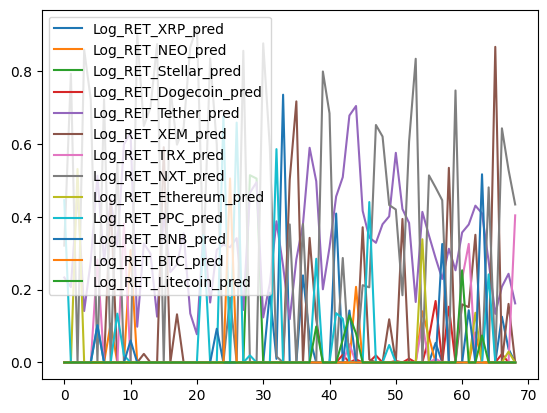

In [86]:
#plot the weights
weights_df = pd.DataFrame(weightsV)
weights_df.plot()

<AxesSubplot:>

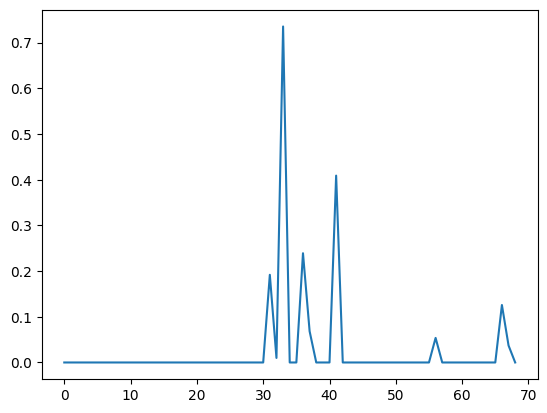

In [87]:
# plot the weights of only 1st coin
weights_df.iloc[:,0].plot()

In [65]:
df_ret_true.iloc[i] 

Log_RET_XRP         0.023326
Log_RET_NEO         0.000200
Log_RET_Stellar     0.017349
Log_RET_Dogecoin   -0.001101
Log_RET_Tether      0.000100
Log_RET_XEM         0.011731
Log_RET_TRX         0.001998
Log_RET_NXT         0.078719
Log_RET_Ethereum   -0.000800
Log_RET_PPC        -0.055513
Log_RET_BNB        -0.006320
Log_RET_BTC         0.010445
Log_RET_Litecoin    0.089384
Name: 69, dtype: float64

In [66]:
n_coins = len(coins)
weights_avg = np.ones(n_coins)/n_coins

In [71]:
#calculate the portfolio returns from the weights and df_ret_true
port_ret = []
for i in range(0, n_test-1):
    ret = np.dot(df_ret_true.iloc[i], weights_df.iloc[i])
    port_ret.append(ret) 

port_ret_hist_mean = []
for i in range(0, n_test-1):
    ret = np.dot(df_ret_true.iloc[i], weights_hist_mean_df.iloc[i])
    port_ret_hist_mean.append(ret) 
# portfolio of 1/n coins
port_ret_avg = []
for i in range(0, n_test-1):
    ret = np.dot(df_ret_true.iloc[i], weights_avg)
    port_ret_avg.append(ret)

In [72]:
#calculate cumulative returns
cum_ret = np.cumprod(1+np.array(port_ret))
cum_ret_avg = np.cumprod(1+np.array(port_ret_avg))
cum_ret_hist_mean = np.cumprod(1+np.array(port_ret_hist_mean))

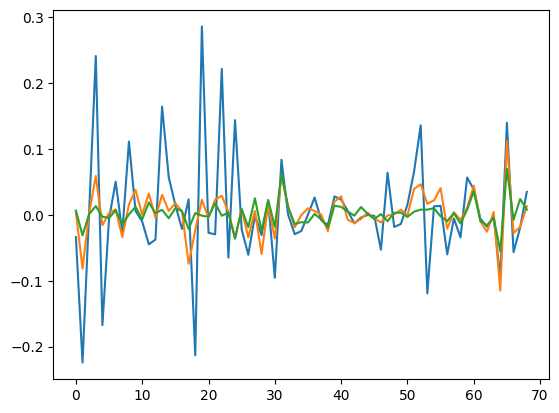

In [73]:
# plot portfolio returns
plt.plot(port_ret)
plt.plot(port_ret_avg)
plt.plot(port_ret_hist_mean)

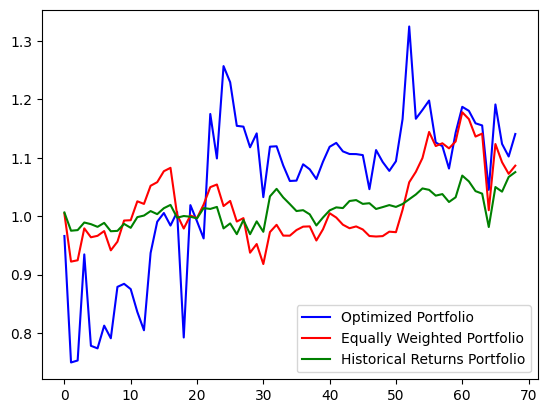

In [106]:
#plot cumulative returns
plt.plot(cum_ret, color="blue", label="Optimized Portfolio") #blue
plt.plot(cum_ret_avg, color='red', label="Equally Weighted Portfolio")
plt.plot(cum_ret_hist_mean, color="green", label="Historical Returns Portfolio")
plt.legend(loc='lower right')
plt.savefig("cum_ret.png")

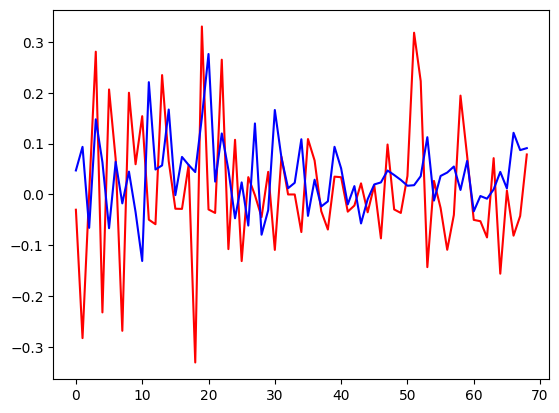

In [102]:
plt.plot(df_ret_true["Log_RET_NXT"], color="red")
plt.plot(df_ret_pred["Log_RET_NXT_pred"], color="blue")

In [98]:
df_ret_pred.shape

(69, 13)